In [1]:
%matplotlib inline
# General modules
import numpy as np
import matplotlib.pyplot as plt

# Project specific modules
from src.collision.fast_spec_col_2d import FastSpectralCollision2D
from src.solver import BC
from src.boltzmann_solver import BoltzmannSolver1D
from src.riemann.advection_1D import advection_1D
from src.solution import Solution
from src.utility import get_config

# Test 1: tend to equilibrium

Considir maxwell molecule:

$$
B_\sigma(|g|, \sigma\cdot \hat{g}) = C_0 b_0(\sigma\cdot\hat{g}).
$$

We start with initial data

$$
f(t,v) = \frac{1}{2\pi K^2}\exp\left(-\frac{v^2}{2K}\right)\left(2K - 1 + \frac{1-K}{2K}v^2\right),
$$

where $K = 1 - \exp(-t/8)/2$ with $t = 0.5$.

We solve the homogeneous Boltzmann equation with heat bath:

$$
\partial_t f = Q_\text{in}(f, f) + \varepsilon \Delta_v f,
$$

with inelasticity parameter $e\approx 1$.

In [2]:
def bkw_f(v, t):
    K = 1 - 0.5*np.exp(-t/8)
    v_norm = (v**2)[:,None] + v**2
    return 1/(2*pi*K**2)*np.exp(-0.5*v_norm/K)*(2*K-1+0.5*v_norm*(1-K)/K)

In [3]:
def ext_Q(v, t):
    f_0 = bkw_f(v, t)
    K = 1 - 0.5*np.exp(-t/8)
    dK = np.exp(-t/8)/16
    v_norm = (v**2)[:,None] + v**2
    df = (-2/K+v_norm/(2*K**2))*f_0 + 1/(2*pi*K**2)*np.exp(-v_norm/(2*K))*(2-v_norm/(2*K**2))
    df = df*dK
    return df

In [23]:
# Import config.json file
config_2d = get_config('./src/configs/config_2D.json')
# Prepare collision
Q = FastSpectralCollision2D(config_2d)

In [24]:
from math import pi
%time np.max(np.abs(Q.col_sep(bkw_f(Q.v, 0.5)) - ext_Q(Q.v, 0.5)))

CPU times: user 70.5 ms, sys: 10.6 ms, total: 81.1 ms
Wall time: 46.7 ms


4.53479319440425e-11

In [25]:
from src.utility import RK4
from tqdm import tnrange

# Set up parameters
eps = 1e-6
dt = 0.1
t = 0
e = 0.95

# Initialize
f = bkw_f(Q.v, 0.)
fs = [f]
ts = [t]

for n in tnrange(1000):
    f = RK4(f, Q.col_heat, eps, dt)
    t += dt
    fs.append(f)
    ts.append(t)

In [26]:
def norm2(f):
    return np.sum(f**2)*Q.dv**2

In [27]:
%%time
f_eq = fs[-1]
errs = []
for f in fs:
    errs.append(norm2(f - f_eq))

## Convergence result with $e = 0.95$, $T = 100$ and $\Delta t = 0.1$.

The following log-log plot shows the exponential decay:

$$
\|f - f_{\infty}\|_{L^2} = O(e^{-\lambda t}).
$$

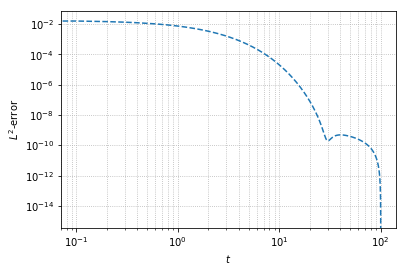

In [39]:
fig, ax = plt.subplots()
ax.grid(which='both', linestyle=':')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$L^2$-error')
ax.loglog(ts, err)

# Test 1: solver validation

The initial data are given by the Maxwellian distributions computed from the macroscopic quantities

\begin{align}
  (\rho_l, u_l, T_l) &= (1, 0, 0.5), \quad &\text{if } 0\leq x\leq 0.5, \\
  (\rho_r, u_r, T_r) &= (0.125, 0, 0.25) \quad &\text{if }0.5<x\leq 1.
\end{align}

Extrapolation boundary condition is applied.

In [13]:
from math import pi
def maxwellian(v, u, T, rho=1.0):
    return rho/(2*pi*T)*np.exp(-((v-u)[:,None]**2+v**2)/(2*T))

# Initialization and boundary conditions
func_l = lambda v: maxwellian(v, 0, 1.)
func_r = lambda v: maxwellian(v, 0, 0.25, 0.125)

In [14]:
soln = Solution(config_2d)
x, v, _ = soln.c_centers
x, v = x[:,0,0], v[0,:,0]

In [15]:
f0 = np.zeros(soln.f.shape)
f0[x<=.5] = func_l(v)*np.ones(x.shape)[x<=.5,None,None]
f0[x>.5] = func_r(v)*np.ones(x.shape)[x>.5,None,None]

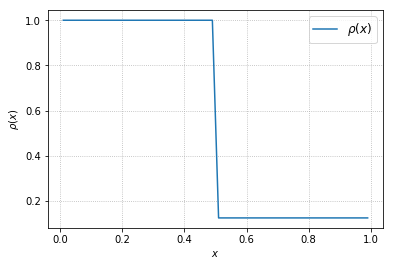

In [16]:
#Initialize
soln.state.f = f0.copy()
soln.t = 0
# Plot
fig, ax = plt.subplots()
ax.plot(x, soln.state.rho, label=r'$\rho(x)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\rho(x)$')
ax.legend(fontsize='large')
ax.grid(which='both',linestyle=':')

In [17]:
solver = BoltzmannSolver1D(1e-4, riemann_solver=advection_1D, collision_operator=Q.col_sep)

solver.dt = 0.002
solver.inner_dt = 1e-4
solver.bc_lower[0] = BC.extrap
solver.bc_upper[0] = BC.extrap
solver.time_integrator = 'PFE'
solver.inner_steps = 5

In [18]:
print("Initial time: {}; time step: {}".format(soln.t, solver.dt))
solver.evolve_to_time(soln, 0.12)

Initial time: 0; time step: 0.002


/Users/zheng/OneDrive/1_Working/2_Inelastic_Projective_Integrator/src/limiters/tvd.py:6: RuntimeWarning: overflow encountered in square
  wave_norm2 = wave**2
/Users/zheng/OneDrive/1_Working/2_Inelastic_Projective_Integrator/src/limiters/tvd.py:10: RuntimeWarning: overflow encountered in multiply
  dotls = wave[1:]*wave[:-1]
/Users/zheng/OneDrive/1_Working/2_Inelastic_Projective_Integrator/src/limiters/tvd.py:13: RuntimeWarning: invalid value encountered in multiply
  r = np.ma.array((spos*dotls[:-1] + (1-spos)*dotls[1:]))
/Users/zheng/OneDrive/1_Working/2_Inelastic_Projective_Integrator/src/collision/fast_spec_col_2d.py:87: RuntimeWarning: overflow encountered in multiply
  * self._fft4(self._ifft4(self._exp*f_hat[..., None, None])*f[..., None, None]), axis=(-1, -2))
/Users/zheng/OneDrive/1_Working/2_Inelastic_Projective_Integrator/src/collision/fast_spec_col_2d.py:90: RuntimeWarning: overflow encountered in multiply
  * self._ifft3(self._j0*f_hat[..., None])*f[..., None], axis=(-1))


KeyboardInterrupt: 

Final time: 0.12


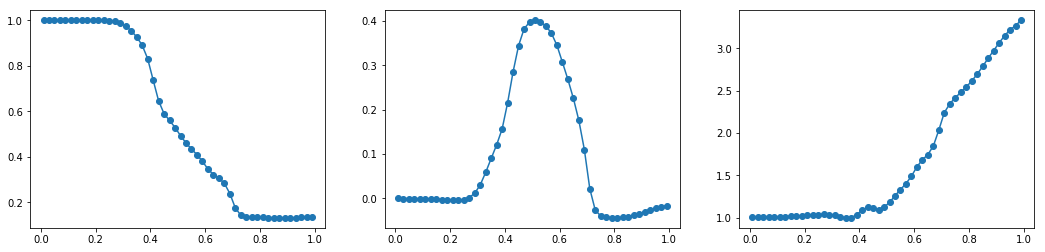

In [10]:
print("Final time: {}".format(soln.t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
# ax[0].plot(x, euler.state.rho, label=r'Euler: $\rho(x)$')
# ax[1].plot(x, euler.state.u[0], label=r'Euler: $u(x)$')
# ax[2].plot(x, euler.state.E/soln.state.rho - 0.5*euler.state.u[0]**2 - 0.5*euler.state.u[1]**2, label=r'Euler: $T(x)$')

ax[0].plot(x, soln.rho, '-o', label=r'PFE: $\rho(x)$')
ax[1].plot(x, soln.u[0], '-o', label=r'PFE: $u(x)$')
ax[2].plot(x, soln.T, '-o', label=r'PFE: $T(x)$')

In [10]:
np.savez('./data_figs/e1.0kn-5_pfe.npz', soln.state.f)

In [15]:
euler = Solution(config_2d)
pfe = Solution(config_2d)
euler.state.f = np.load('./data_figs/e0.8kn-2_euler.npz')['arr_0']
pfe.state.f = np.load('./data_figs/e0.8kn-2_pfe.npz')['arr_0']

0.10000000000000007


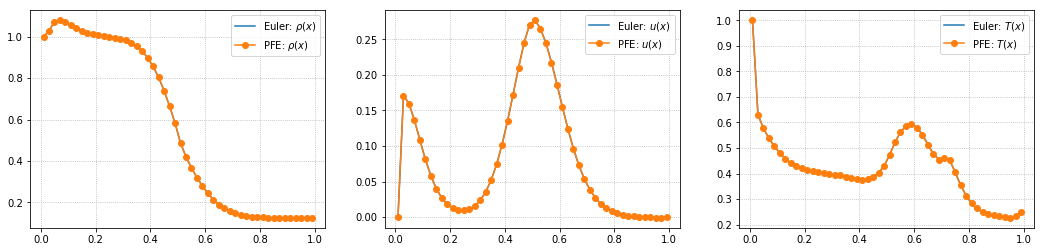

In [17]:
print(soln.state.t)
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ax[0].plot(x, euler.state.rho, label=r'Euler: $\rho(x)$')
ax[1].plot(x, euler.state.u[0], label=r'Euler: $u(x)$')
ax[2].plot(x, euler.state.E/soln.state.rho - 0.5*euler.state.u[0]**2 - 0.5*euler.state.u[1]**2, label=r'Euler: $T(x)$')

ax[0].plot(x, pfe.state.rho, '-o', label=r'PFE: $\rho(x)$')
ax[1].plot(x, pfe.state.u[0], '-o', label=r'PFE: $u(x)$')
ax[2].plot(x, pfe.state.E/soln.state.rho - 0.5*pfe.state.u[0]**2 - 0.5*pfe.state.u[1]**2, '-o', label=r'PFE: $T(x)$')

for i in range(3):
    ax[i].legend()
    ax[i].grid(which='both',linestyle=':')
    
plt.savefig('./data_figs/e0.8kn-2.pdf')

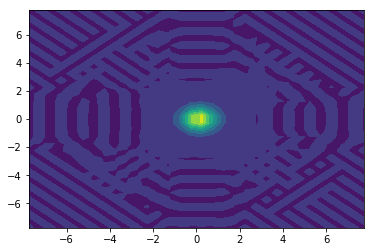

In [84]:
"""Plot the contour in velocity space for given index i"""
i = 28
fig, ax = plt.subplots()
cs = ax.contourf(euler.c_centers[-2][i], euler.c_centers[-1][i], euler.state.f[20])

# ax.clabel(cs, inline=0.5)
plt.savefig('./data_figs/e0.8kn-2_f.pdf')

In [75]:
rho_e_3 = np.copy(soln.state.rho)

0.1500000000000001


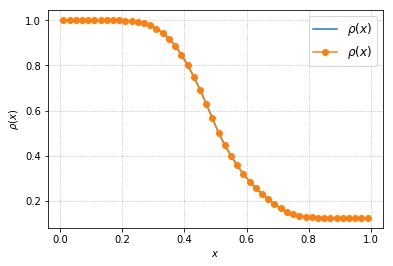

In [82]:
print(soln.state.t)
fig, ax = plt.subplots()
ax.plot(x, soln.state.rho, x, rho_e_3, 'o-', label=r'$\rho(x)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\rho(x)$')
ax.legend(fontsize='large')
ax.grid(which='both',linestyle=':')

# Test 2:

Considier the following initial condition:



In [51]:
from math import pi
def maxwellian_vectorized(v, u, T, rho):
    return rho[:,None,None]/(2*pi*T)*np.exp(-((v-u)[:,None]**2+v**2)/(2*T))

In [52]:
soln = Solution(config_2d)
x, v, _ = soln.c_centers
x, v = x[:,0,0], v[0,:,0]

In [53]:
rho = 1. + 0.1*np.random.normal(0, 0.01, x.shape[0])
f0 = np.empty(soln.f.shape)
f0 = maxwellian_vectorized(v, 0., 1., rho)

Initial time: 0


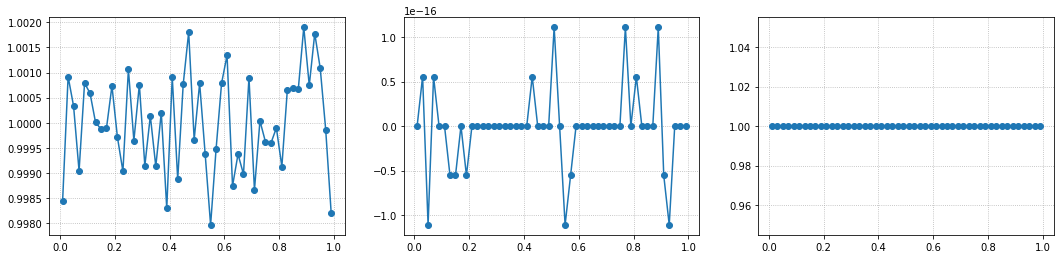

In [54]:
#Initialize
soln.state.f = f0.copy()
soln.t = 0
# Plot
print("Initial time: {}".format(soln.t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ax[0].plot(x, soln.rho, '-o')
ax[1].plot(x, soln.u[0], '-o')
ax[2].plot(x, soln.T, '-o')
for iax in ax:
    iax.grid(which='both',linestyle=':')

In [55]:
solver = BoltzmannSolver1D(1.)

solver.bc_lower[0] = BC.periodic
solver.bc_upper[0] = BC.periodic

solver.dt = 0.002
solver.time_integrator = 'Euler'
solver.inner_steps = 2

solver.rp = advection_1D
solver.collision = lambda f: Q.col_heat(f, 1e-6)

In [56]:
print("Initial time: {}; time step: {}".format(soln.t, solver.dt))
solver.evolve_to_time(soln, 0.1)

Initial time: 0; time step: 0.002


Final time: 0.1


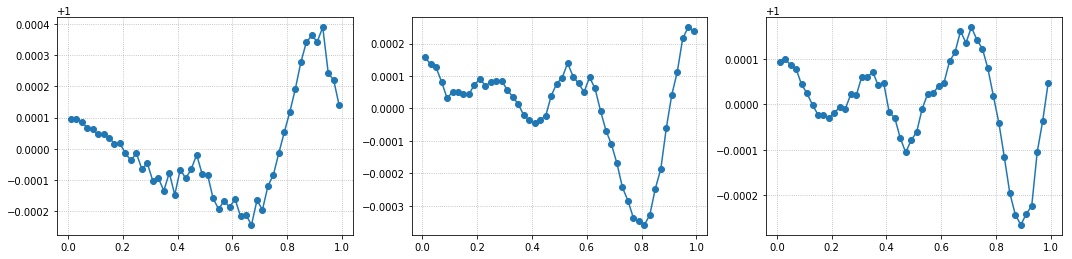

In [57]:
print("Final time: {}".format(soln.t))
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
# ax[0].plot(x, euler.state.rho, label=r'Euler: $\rho(x)$')
# ax[1].plot(x, euler.state.u[0], label=r'Euler: $u(x)$')
# ax[2].plot(x, euler.state.E/soln.state.rho - 0.5*euler.state.u[0]**2 - 0.5*euler.state.u[1]**2, label=r'Euler: $T(x)$')

ax[0].plot(x, soln.rho, '-o', label=r'PFE: $\rho(x)$')
ax[1].plot(x, soln.u[0], '-o', label=r'PFE: $u(x)$')
ax[2].plot(x, soln.T, '-o', label=r'PFE: $T(x)$')
for iax in ax:
    iax.grid(which='both',linestyle=':')